In [1]:
!nvidia-smi

Tue Jan 21 14:11:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!wget https://raw.githubusercontent.com/DBertazioli/host/master/datas/df_final_processed.csv

--2020-01-21 14:11:12--  https://raw.githubusercontent.com/DBertazioli/host/master/datas/df_final_processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22162490 (21M) [text/plain]
Saving to: ‘df_final_processed.csv’

df_final_processed. 100%[===================>]  21.14M  39.0MB/s    in 0.5s    

2020-01-21 14:11:13 (39.0 MB/s) - ‘df_final_processed.csv’ saved [22162490/22162490]



In [3]:
!pip install pyforest
from pyforest import *

  Created wheel for pyforest: filename=pyforest-1.0.2-py2.py3-none-any.whl size=13557 sha256=9ff8c58e4b5cc73f47f955193673c6df3ada933fbd9f067848e631f49eba682c
  Stored in directory: /root/.cache/pip/wheels/e2/1b/b1/f7ff0a6aee79ec158aea4a339d7bd722deb261f65d8c9968c2
Successfully built pyforest


In [4]:
from IPython.display import clear_output
class TrainingPlot(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        #self.f1=[]
        #self.val_f1=[]
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('mean_absolute_error'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_mean_absolute_error'))
        #self.f1.append(logs.get('f1'))
        #self.val_f1.append(logs.get('val_f1'))
        
        if len(self.losses)%5==0:
            
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            #%matplotlib inline
            plt.style.use("seaborn")
            plt.figure()
            plt.plot(N, self.losses, label = "train_mse")
            plt.plot(N, self.acc, label = "train_mae")
            plt.plot(N, self.val_losses, label = "val_mse")
            plt.plot(N, self.val_acc, label = "val_mae")
            #plt.plot(N, self.f1, label = "f1")
            #plt.plot(N, self.val_f1, label = "val_f1")
            plt.ylim(0,0.1)
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss(Mse)/Mae")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

Using TensorFlow backend.


<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv("df_final_processed.csv", index_col = 0)
df.head()

<IPython.core.display.Javascript object>

,datetime,level,rain,vel_wind,dir_wind,level_std,level_scaled,dist,dist_std,dist_scaled,ts,inv_dist,inv_dist_std,inv_dist_scaled,inv_dist_2,inv_dist_2_std,inv_dist_2_scaled
0,2010-01-01 00:00:00,102.0,0.0,0.2,337.5,2.461852,0.763636,353510.208614,-2.034933,0.043682,1262304000000000000,0.000003,2.156252,0.949046,8.001955e-12,2.219529,0.945147
1,2010-01-01 01:00:00,100.0,0.0,0.7,315.0,2.389875,0.754545,353731.458075,-2.020637,0.047277,1262307600000000000,0.000003,2.139458,0.944887,7.991948e-12,2.201361,0.940688
2,2010-01-01 02:00:00,86.0,0.0,1.5,247.5,1.886035,0.690909,354197.433405,-1.990529,0.054849,1262311200000000000,0.000003,2.104155,0.936144,7.970933e-12,2.163208,0.931324
3,2010-01-01 03:00:00,74.0,0.0,1.3,247.5,1.454172,0.636364,354875.253700,-1.946732,0.065863,1262314800000000000,0.000003,2.052969,0.923467,7.940513e-12,2.107977,0.917768
4,2010-01-01 04:00:00,65.0,0.0,1.3,247.5,1.130275,0.595455,355718.662776,-1.892236,0.079569,1262318400000000000,0.000003,1.989551,0.907761,7.902904e-12,2.039695,0.901010


In [17]:
split_index = -7*24

df[split_index:]

,datetime,level,rain,vel_wind,dir_wind,level_std,level_scaled,dist,dist_std,dist_scaled,ts,inv_dist,inv_dist_std,inv_dist_scaled,inv_dist_2,inv_dist_2_std,inv_dist_2_scaled
78720,2018-12-25 00:00:00,52.0,0.0,0.9,292.5,0.662424,0.536364,355892.715603,-1.880990,0.082397,1545696000000000000,0.000003,1.976501,0.904529,7.895176e-12,2.025664,0.897566
78721,2018-12-25 01:00:00,54.0,0.0,0.8,315.0,0.734401,0.545455,355680.557154,-1.894698,0.078949,1545699600000000000,0.000003,1.992410,0.908469,7.904597e-12,2.042769,0.901764
78722,2018-12-25 02:00:00,47.0,0.0,1.5,247.5,0.482481,0.513636,355738.063902,-1.890983,0.079884,1545703200000000000,0.000003,1.988095,0.907401,7.902042e-12,2.038130,0.900625
78723,2018-12-25 03:00:00,30.0,0.0,1.8,247.5,-0.129324,0.436364,356065.131351,-1.869850,0.085199,1545706800000000000,0.000003,1.963586,0.901331,7.887532e-12,2.011785,0.894160
78724,2018-12-25 04:00:00,13.0,0.0,1.5,225.0,-0.741129,0.359091,356644.343771,-1.832424,0.094611,1545710400000000000,0.000003,1.920291,0.890609,7.861933e-12,1.965308,0.882753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78883,2018-12-31 19:00:00,8.0,0.0,1.6,22.5,-0.921072,0.336364,391447.768733,0.416360,0.660158,1546282800000000000,0.000003,-0.446021,0.304572,6.526079e-12,-0.460040,0.287493
78884,2018-12-31 20:00:00,11.0,0.0,1.8,22.5,-0.813106,0.350000,391516.944021,0.420830,0.661282,1546286400000000000,0.000003,-0.450305,0.303511,6.523774e-12,-0.464227,0.286466
78885,2018-12-31 21:00:00,9.0,0.0,1.8,45.0,-0.885084,0.340909,391314.329393,0.407738,0.657989,1546290000000000000,0.000003,-0.437752,0.306620,6.530531e-12,-0.451958,0.289477
78886,2018-12-31 22:00:00,3.0,0.0,1.8,45.0,-1.101015,0.313636,390864.167549,0.378651,0.650674,1546293600000000000,0.000003,-0.409815,0.313539,6.545582e-12,-0.424631,0.296184


In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

series = df.level_std.values
split_index = -7*24

test_series = series [split_index:]
series = series [:split_index]
n_features = 1
series = series.reshape((len(series), n_features))
test_series = test_series.reshape((len(test_series), n_features))

series.shape


(78720, 1)

In [0]:
# define generator
n_input = 1*24
train_generator = TimeseriesGenerator(series, series, length=n_input, batch_size=256)
test_generator = TimeseriesGenerator(test_series, test_series, length=n_input, batch_size=8)

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# define model
model = Sequential()
model.add(LSTM(1024, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(512, activation='relu', return_sequences=True))
#model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu'))
#model.add(Dense(64, activation = "relu" ))
model.add(Dense(1) )
model.compile(optimizer='adam', loss='mse', metrics = ["mae"])
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 1024)          4202496   
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 512)           3147776   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,678,593
Trainable params: 7,678,593
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

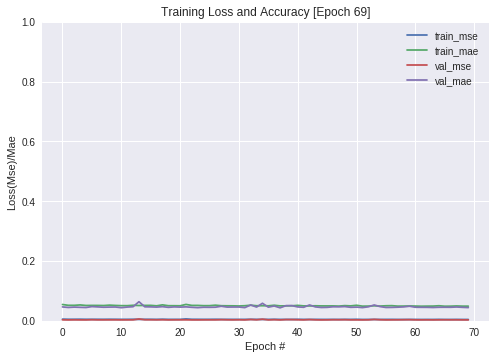

Epoch 71/100
308/308 [==============================] - 53s 171ms/step - loss: 0.0045 - mean_absolute_error: 0.0495 - val_loss: 0.0031 - val_mean_absolute_error: 0.0440
Epoch 72/100
281/308 [==========================>...] - ETA: 4s - loss: 0.0045 - mean_absolute_error: 0.0492

In [0]:
# fit model
history1 = model.fit_generator(train_generator,  epochs=100, verbose=1, validation_data=test_generator, callbacks=[plot_losses])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[]

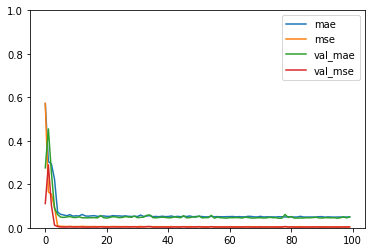

In [0]:
plt.plot(history.history["mean_absolute_error"], label = "mae")
plt.plot(history.history["mean_squared_error"], label = "mse")
plt.plot(history.history["val_mean_absolute_error"], label = "val_mae")
plt.plot(history.history["val_mean_squared_error"], label = "val_mse")
plt.ylim((0,1))
plt.legend()
plt.plot()

In [0]:
# make a one step prediction out of sample
x_input = array([9, 10]).reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

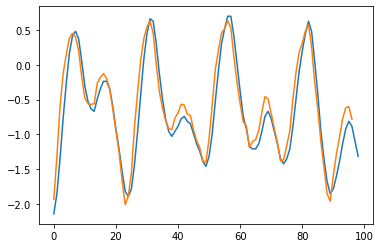

In [0]:
plt.plot(test_series[1:])
plt.plot(model.predict_generator(test_generator)[:-1])

In [0]:
for x, y in test_generator:
  print(x)
  print("#")
  print(y)
  break

[[[-2.21666001]
  [-2.1446829 ]]

 [[-2.1446829 ]
  [-1.85677448]]

 [[-1.85677448]
  [-1.35293474]]

 [[-1.35293474]
  [-0.77711789]]

 [[-0.77711789]
  [-0.27327815]]

 [[-0.27327815]
  [ 0.15858448]]

 [[ 0.15858448]
  [ 0.41050435]]

 [[ 0.41050435]
  [ 0.48248146]]]
#
[[-1.85677448]
 [-1.35293474]
 [-0.77711789]
 [-0.27327815]
 [ 0.15858448]
 [ 0.41050435]
 [ 0.48248146]
 [ 0.3745158 ]]


In [0]:
model.evaluate_generator(test_generator)

[0.022409923222600197, 0.12407879561794047, 0.022409923222600197]